<a href="https://colab.research.google.com/github/Sameer-Tahir/Project_DS/blob/main/DL_Models/XGBoost_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Sameer-Tahir/Project_DS.git

Cloning into 'Project_DS'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 302 (delta 73), reused 6 (delta 6), pack-reused 113 (from 1)
Receiving objects: 100% (302/302), 16.75 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [19]:
# !pip install optuna optuna-dashboard


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.8/103.8 kB 7.9 MB/s eta 0:00:00


In [9]:
# Import libraries
import pandas as pd   # data processing
import numpy as np    # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import json
from tensorflow.keras import layers, models, callbacks
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras import layers, models, callbacks
import numpy as np, joblib
from sklearn.metrics import precision_recall_fscore_support
import tensorflow as tf
from tensorflow.keras import layers, models
import xgboost as xgb
import lightgbm as lgb
from xgboost.callback import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [3]:
# -----------------------
# Load your splits
# -----------------------
train_df = pd.read_csv("dfk1_train.csv")
val_df   = pd.read_csv("dfk1_val.csv")
test_df  = pd.read_csv("dfk1_test.csv")

In [4]:
!unzip -o dl_preprocessed.zip

Archive:  dl_preprocessed.zip
  inflating: dl_data_windows.npz     
  inflating: label_encoder.pkl       
  inflating: scaler.pkl              


In [5]:
# Load arrays
data = np.load("dl_data_windows.npz", allow_pickle=True)
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val     = data["X_val"],   data["y_val"]
X_test, y_test   = data["X_test"],  data["y_test"]
feature_cols     = data["feature_cols"].tolist()
classes          = data["classes"]

# Load encoder & scaler
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")

print("✅ Data loaded successfully")
print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape, y_val.shape)
print("Test:",  X_test.shape, y_test.shape)
print("Classes:", classes)

✅ Data loaded successfully
Train: (4835, 6, 222) (4835,)
Val: (591, 6, 222) (591,)
Test: (590, 6, 222) (590,)
Classes: ['aggressive-scan' 'cryptojacking' 'icmp-flood' 'icmp-fragmentation'
 'icmp-fragmentation_old' 'none' 'os-fingerprinting' 'os-scan' 'port-scan'
 'push-ack-flood' 'serice-detection' 'service-detection' 'syn-flood'
 'syn-stealth' 'synonymous-ip-flood' 'tcp-flood' 'udp-flood' 'vuln-scan']


In [11]:
import xgboost as xgb
print(xgb.__version__)

3.0.4


[0]	validation_0-mlogloss:2.53294
[1]	validation_0-mlogloss:2.29571
[2]	validation_0-mlogloss:2.11347
[3]	validation_0-mlogloss:1.96366
[4]	validation_0-mlogloss:1.83579
[5]	validation_0-mlogloss:1.72497
[6]	validation_0-mlogloss:1.62875
[7]	validation_0-mlogloss:1.54270
[8]	validation_0-mlogloss:1.46555
[9]	validation_0-mlogloss:1.39480
[10]	validation_0-mlogloss:1.33139
[11]	validation_0-mlogloss:1.27255
[12]	validation_0-mlogloss:1.21686
[13]	validation_0-mlogloss:1.16671
[14]	validation_0-mlogloss:1.12054
[15]	validation_0-mlogloss:1.07602
[16]	validation_0-mlogloss:1.03448
[17]	validation_0-mlogloss:0.99605
[18]	validation_0-mlogloss:0.95941
[19]	validation_0-mlogloss:0.92562
[20]	validation_0-mlogloss:0.89315
[21]	validation_0-mlogloss:0.86323
[22]	validation_0-mlogloss:0.83589
[23]	validation_0-mlogloss:0.80884
[24]	validation_0-mlogloss:0.78226
[25]	validation_0-mlogloss:0.75776
[26]	validation_0-mlogloss:0.73429
[27]	validation_0-mlogloss:0.71290
[28]	validation_0-mlogloss:0.6

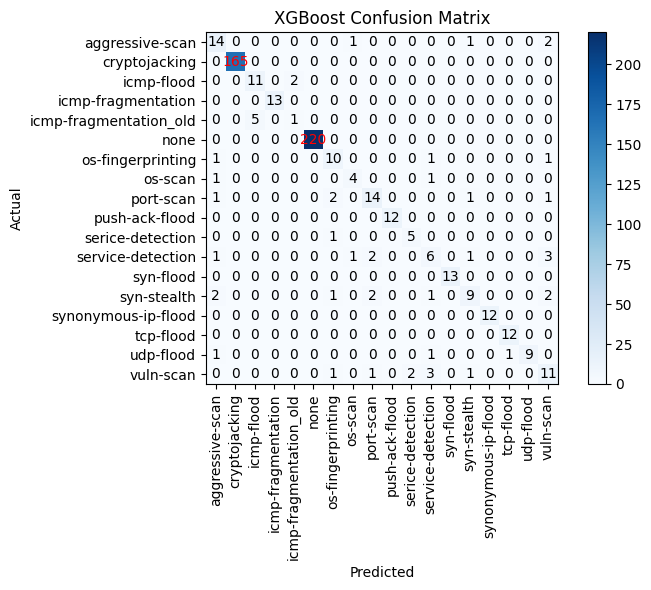

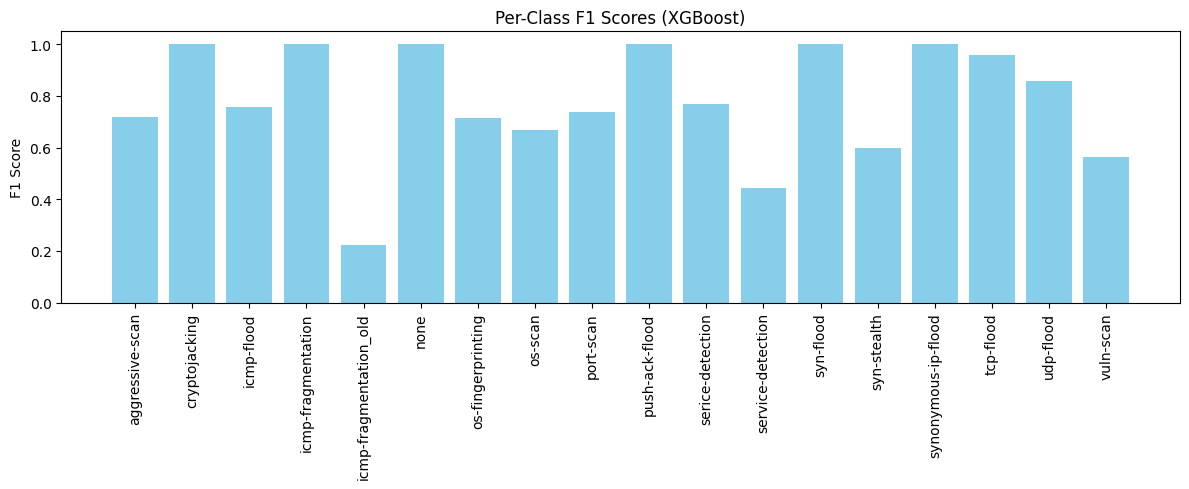

<Figure size 1000x600 with 0 Axes>

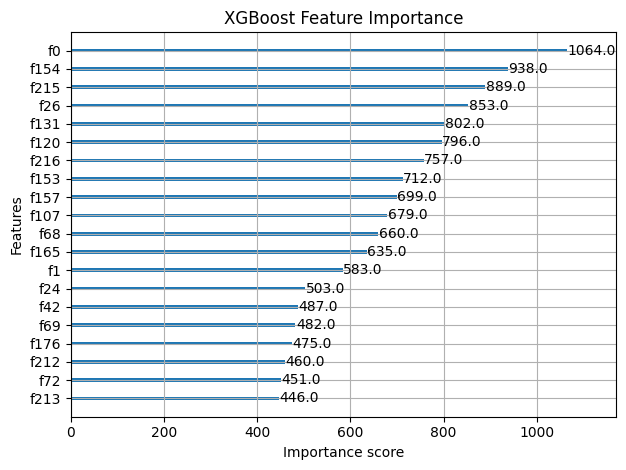

TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [14]:
# -----------------------
# Flatten time-series to tabular for boosting
# -----------------------
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# ================================================================
# XGBoost
# ================================================================
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=len(classes),
    eval_metric="mlogloss",
    tree_method="hist"
)

# Train with evaluation set
xgb_model.fit(
    X_train_flat, y_train,
    eval_set=[(X_val_flat, y_val)],
    verbose=True
)

# Best iteration workaround
results = xgb_model.evals_result()
val_loss = results["validation_0"]["mlogloss"]
best_iter = int(np.argmin(val_loss))
print(f"Best iteration (manual): {best_iter}")

# Predict
y_pred_xgb = xgb_model.predict(X_test_flat, iteration_range=(0, best_iter+1))

# Metrics
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average="macro")
report_xgb = classification_report(y_test, y_pred_xgb, target_names=classes, zero_division=0)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\n✅ XGBoost Results")
print("Accuracy:", acc_xgb)
print("Macro-F1:", f1_xgb)
print(report_xgb)

# Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_xgb, cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm_xgb.shape[0]):
    for j in range(cm_xgb.shape[1]):
        plt.text(j, i, cm_xgb[i, j], ha="center", va="center",
                 color="red" if cm_xgb[i, j] > cm_xgb.max()/2 else "black")
plt.tight_layout()
plt.savefig("XGBoost_confusion_matrix.png")
plt.show()

# Per-class F1 (XGBoost)
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred_xgb, zero_division=0)
plt.figure(figsize=(12, 5))
plt.bar(classes, f1, color="skyblue")
plt.xticks(rotation=90)
plt.title("Per-Class F1 Scores (XGBoost)")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.savefig("XGBoost_f1_per_class.png")
plt.show()

# Save Results
results_xgb = {
    "accuracy": float(acc_xgb),
    "macro_f1": float(f1_xgb),
    "report": report_xgb,
    "confusion_matrix": cm_xgb.tolist()
}
with open("results_xgboost.json", "w") as f:
    json.dump(results_xgb, f, indent=4)

✅ XGBoost Results
Accuracy: 0.9169491525423729
Macro-F1: 0.778417041720127

Final feature shape: (4835, 2442)


[I 2025-09-15 10:14:41,294] A new study created in memory with name: no-name-4587a9bc-a6a3-484e-9d46-a8dd3e1bb787
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:209: UserWarning: [10:14:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return getattr(self.bst, name)(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:215: UserWarning: [10:14:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:215: UserWarning: [10:14:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  self.bst.update(self.dtrain, iteration, fobj)
[I 2025-09-15 10:49:58,810] Trial 0 finished with value: 0.6570029080638597 and parameters: {'n_estimators': 442, 'max_depth': 10, 'learning_rate': 0.018551469207731073, 'subsample': 0.8086413944739708, 'colsampl

Best hyperparameters: {'n_estimators': 540, 'max_depth': 4, 'learning_rate': 0.09806053484398389, 'subsample': 0.9016920425518182, 'colsample_bytree': 0.6307972181040903, 'gamma': 1.6299798167869517, 'min_child_weight': 2}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:18:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-mlogloss:2.20593
[1]	validation_0-mlogloss:1.88719
[2]	validation_0-mlogloss:1.66549
[3]	validation_0-mlogloss:1.49338
[4]	validation_0-mlogloss:1.35469
[5]	validation_0-mlogloss:1.23970
[6]	validation_0-mlogloss:1.14085
[7]	validation_0-mlogloss:1.05525
[8]	validation_0-mlogloss:0.98002
[9]	validation_0-mlogloss:0.91352
[10]	validation_0-mlogloss:0.85424
[11]	validation_0-mlogloss:0.80269
[12]	validation_0-mlogloss:0.75523
[13]	validation_0-mlogloss:0.71322
[14]	validation_0-mlogloss:0.67638
[15]	validation_0-mlogloss:0.64248
[16]	validation_0-mlogloss:0.61133
[17]	validation_0-mlogloss:0.58348
[18]	validation_0-mlogloss:0.55769
[19]	validation_0-mlogloss:0.53443
[20]	validation_0-mlogloss:0.51311
[21]	validation_0-mlogloss:0.49293
[22]	validation_0-mlogloss:0.47579
[23]	validation_0-mlogloss:0.45965
[24]	validation_0-mlogloss:0.44534
[25]	validation_0-mlogloss:0.43144
[26]	validation_0-mlogloss:0.42047
[27]	validation_0-mlogloss:0.40834
[28]	validation_0-mlogloss:0.3

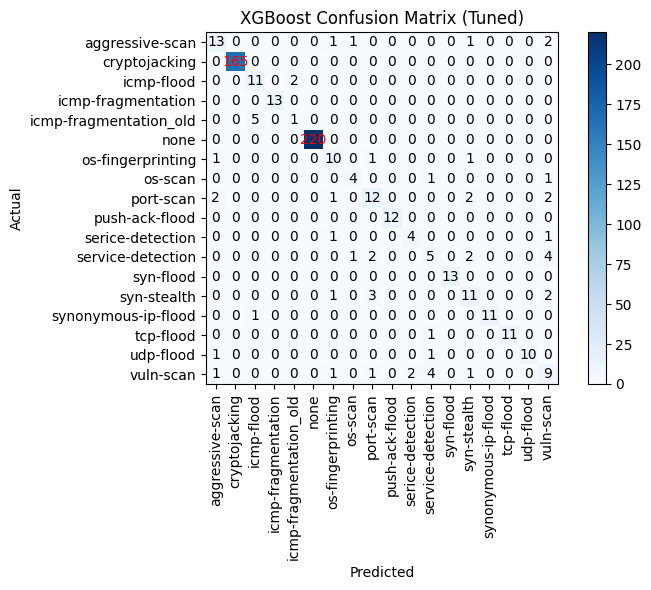

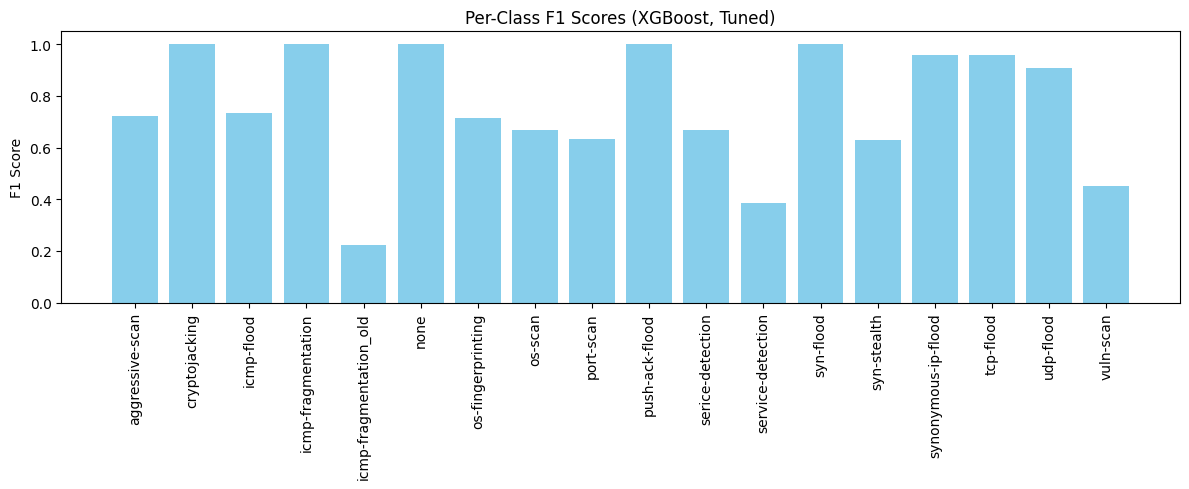

/tmp/ipython-input-1542410286.py:149: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_all[:200], feature_names=[f"f{i}" for i in range(X_test_all.shape[1])])
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr

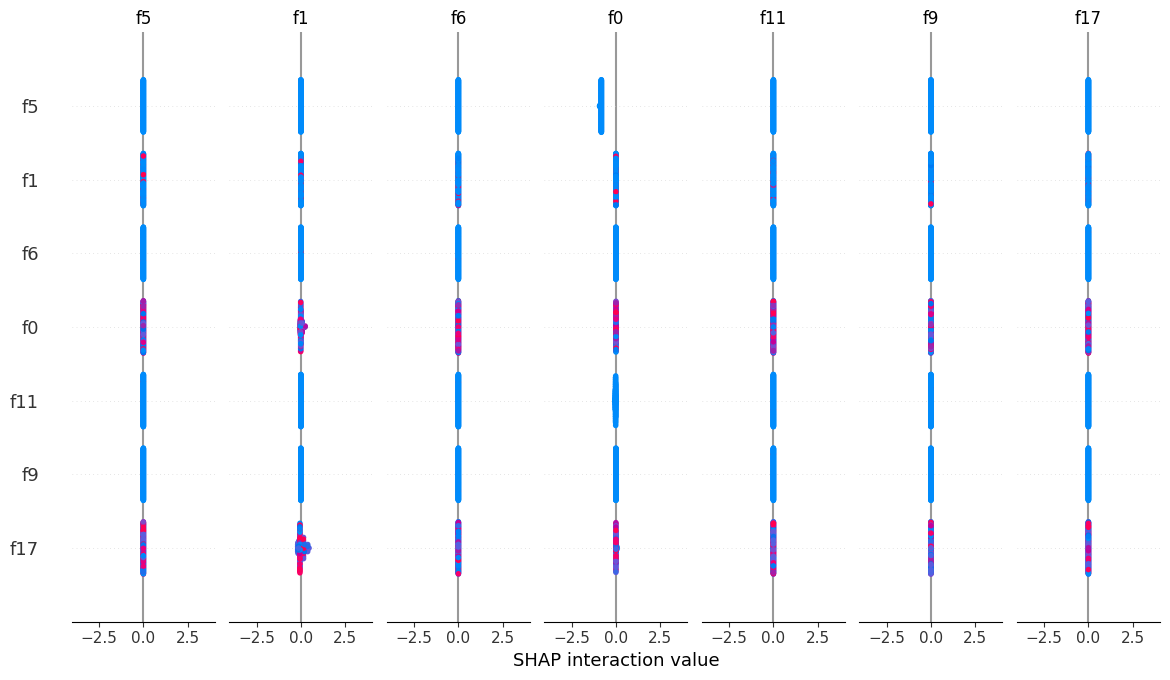

📂 Saved: tuned model results, confusion matrix, F1 plots, SHAP plots


In [21]:
# -----------------------
# Flatten + Feature Engineering
# -----------------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Flatten raw
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Add simple statistical features from each time-series window
def extract_features(X):
    feats = []
    for sample in X:
        stats = []
        stats.extend(np.mean(sample, axis=0))
        stats.extend(np.std(sample, axis=0))
        stats.extend(np.min(sample, axis=0))
        stats.extend(np.max(sample, axis=0))
        stats.extend(np.median(sample, axis=0))
        feats.append(stats)
    return np.array(feats)

X_train_feats = extract_features(X_train)
X_val_feats = extract_features(X_val)
X_test_feats = extract_features(X_test)

# Concatenate raw + engineered
X_train_all = np.hstack([X_train_flat, X_train_feats])
X_val_all = np.hstack([X_val_flat, X_val_feats])
X_test_all = np.hstack([X_test_flat, X_test_feats])

# Normalize features
scaler = StandardScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_val_all = scaler.transform(X_val_all)
X_test_all = scaler.transform(X_test_all)

print("Final feature shape:", X_train_all.shape)

# ================================================================
# Hyperparameter Tuning with Optuna (efficient version)
# ================================================================
import optuna
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_all, label=y_train)

def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": len(classes),
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=600,
        nfold=3,
        early_stopping_rounds=20,
        seed=42,
        metrics="mlogloss",
        verbose_eval=False
    )
    return 1.0 - cv_results["test-mlogloss-mean"].min()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, timeout=3600)  # ⏱️ limit to 1 hour or 15 trials
best_params = study.best_params
print("Best hyperparameters:", best_params)

# ================================================================
# Train Final Model with Class Weights
# ================================================================
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
scale_pos_weight = np.max(weights) / np.min(weights)
best_params["scale_pos_weight"] = scale_pos_weight

xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train_all, y_train, eval_set=[(X_val_all, y_val)], verbose=True)

# Predict
y_pred_xgb = xgb_model.predict(X_test_all)

# ================================================================
# Evaluation
# ================================================================
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import json

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average="macro")
report_xgb = classification_report(y_test, y_pred_xgb, target_names=classes, zero_division=0)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

print("\n✅ XGBoost Results (Tuned)")
print("Accuracy:", acc_xgb)
print("Macro-F1:", f1_xgb)
print(report_xgb)

# Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_xgb, cmap="Blues")
plt.title("XGBoost Confusion Matrix (Tuned)")
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=90)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(cm_xgb.shape[0]):
    for j in range(cm_xgb.shape[1]):
        plt.text(j, i, cm_xgb[i, j], ha="center", va="center",
                 color="red" if cm_xgb[i, j] > cm_xgb.max()/2 else "black")
plt.tight_layout()
plt.savefig("XGBoost_confusion_matrix_tuned.png")
plt.show()

# Per-class F1
prec, rec, f1, support = precision_recall_fscore_support(y_test, y_pred_xgb, zero_division=0)
plt.figure(figsize=(12, 5))
plt.bar(classes, f1, color="skyblue")
plt.xticks(rotation=90)
plt.title("Per-Class F1 Scores (XGBoost, Tuned)")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.savefig("XGBoost_f1_per_class_tuned.png")
plt.show()

# ================================================================
# Interpretability with SHAP
# ================================================================
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_all[:200])  # ⚡ limit for speed

shap.summary_plot(shap_values, X_test_all[:200], feature_names=[f"f{i}" for i in range(X_test_all.shape[1])])

# Save Results
results_xgb = {
    "accuracy": float(acc_xgb),
    "macro_f1": float(f1_xgb),
    "report": report_xgb,
    "confusion_matrix": cm_xgb.tolist(),
    "best_params": best_params
}
with open("results_xgboost_tuned.json", "w") as f:
    json.dump(results_xgb, f, indent=4)

print("📂 Saved: tuned model results, confusion matrix, F1 plots, SHAP plots")
